In [120]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import Lipinski, Crippen, rdMolDescriptors
from rdkit import Chem
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

In [2]:
# loading data
data = pd.read_csv("train.csv")
X, y, smiles = data.drop(["Tm","id","SMILES"], axis=1), data["Tm"], data["SMILES"]

In [3]:
X

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2660,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
smiles

0             FC1=C(F)C(F)(F)C1(F)F
1       c1ccc2c(c1)ccc3Nc4ccccc4c23
2               CCN1C(C)=Nc2ccccc12
3                        CC#CC(=O)O
4                         CCCCC(S)C
                   ...             
2657                         ClCCBr
2658                 N#CC(Cl)(Cl)Cl
2659             Cc1ccc2c(C)cccc2c1
2660          CCC(=O)c1ccc2ccccc2c1
2661              Brc1ccc(cc1)N(C)C
Name: SMILES, Length: 2662, dtype: object

In [5]:
def extract_features(smiles: str):
    """
    Extracting chemical features using Chem library
    """
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return {
        # Composition & mass
        "ExactMolWt": rdMolDescriptors.CalcExactMolWt(mol),

        # Physicochemical descriptors
        "LogP": Crippen.MolLogP(mol),
        "TPSA": rdMolDescriptors.CalcTPSA(mol),
        "Fraction_CSP3": rdMolDescriptors.CalcFractionCSP3(mol),
        "Formal_Charge": sum(atom.GetFormalCharge() for atom in mol.GetAtoms()),

        # Topology
        "Num_Rings": rdMolDescriptors.CalcNumRings(mol),
        "Num_Aromatic_Rings": rdMolDescriptors.CalcNumAromaticRings(mol),
        "Rotatable_Bonds": Lipinski.NumRotatableBonds(mol),

        # Atomic composition
        "Heavy_Atom_Count": rdMolDescriptors.CalcNumHeavyAtoms(mol),
        "Num_Heteroatoms": rdMolDescriptors.CalcNumHeteroatoms(mol),
        "Num_StereoCenters": rdMolDescriptors.CalcNumAtomStereoCenters(mol),

        # H-bonding / Drug-likeness features
        "HBA": Lipinski.NumHAcceptors(mol),
        "HBD": Lipinski.NumHDonors(mol),
    }

features_list = [extract_features(s) for s in smiles]
df_custom_features = pd.DataFrame([f for f in features_list if f is not None])
print(df_custom_features)

      ExactMolWt     LogP   TPSA  Fraction_CSP3  Formal_Charge  Num_Rings  \
0     161.990419  2.42120   0.00       0.500000              0          1   
1     217.089149  4.47430  15.79       0.000000              0          4   
2     160.100048  2.36462  17.82       0.300000              0          2   
3      84.021129  0.09430  37.30       0.250000              0          0   
4     118.081621  2.49490   0.00       1.000000              0          0   
...          ...      ...    ...            ...            ...        ...   
2657  141.918490  1.62010   0.00       1.000000              0          0   
2658  142.909632  1.88018  23.79       0.500000              0          0   
2659  156.093900  3.45664   0.00       0.166667              0          2   
2660  184.088815  3.43250  17.07       0.153846              0          2   
2661  198.999661  2.51510   3.24       0.250000              0          1   

      Num_Aromatic_Rings  Rotatable_Bonds  Heavy_Atom_Count  Num_Heteroatom

In [6]:
def element_counts(smiles: str):
    """
    Counting the number of chemical elements
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # List of element symbols in the molecule
    elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
    return dict(Counter(elements))

counts = []
for s in smiles:
    counts.append(element_counts(s))
    
df_chemical_elements = pd.DataFrame(counts).fillna(0)

In [8]:
# combining features together

df = pd.concat([X, df_custom_features], axis=1)
df = pd.concat([df, df_chemical_elements], axis=1)

df.head()

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,...,F,C,N,O,S,Cl,Br,P,Si,I
0,0,0,0,0,0,0,0,0,0,0,...,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0,0,0,0,0,0,0,0,...,0.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,3,0,0,0,0,0,0,0,0,...,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Tasks:
1. Split data
2. Standardize
3. Feature selection (MI / RF-FI)
4. Modelling with hyper-parameter tuning

In [10]:
# splitting data

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2129, 447) (533, 447) (2129,) (533,)


In [14]:
X_train

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,...,F,C,N,O,S,Cl,Br,P,Si,I
2130,2,25,0,0,0,0,0,0,0,0,...,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1882,1,0,0,0,0,0,0,0,0,0,...,0.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2066,2,4,0,1,0,0,0,0,0,0,...,0.0,7.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1614,0,2,1,0,0,0,0,0,0,0,...,0.0,3.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
279,0,0,0,0,0,0,0,0,0,0,...,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,4,0,0,0,0,0,0,2,0,0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1095,3,41,1,0,0,0,0,0,0,0,...,0.0,51.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1130,3,0,0,0,0,0,0,0,0,0,...,0.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,0,0,0,0,0,0,0,0,0,0,...,0.0,13.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# normalization

# we have mainly counting features, they are non-negative, so min-max scaling may be the best option

feature_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

os.makedirs("scalers", exist_ok=True)
joblib.dump(feature_scaler, "scalers/feature_scaler.pkl")
joblib.dump(y_scaler, "scalers/y_scaler.pkl")

['scalers/y_scaler.pkl']

## Dimensionality reduction/feature selection
#### Important note: the 'optimal' number of features was selected based on results on the test set, it would be better to extract additional validation set for this purpose or perform cross-validation

### PCA approach

In [104]:
# dimensionality reduction

n_feature_list = []
mae_list = []

for v in np.linspace(0.1, 0.9, 9):
    pca = PCA(n_components=v)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    model = RandomForestRegressor(criterion='absolute_error', n_estimators=100, random_state=42, n_jobs=-1) # optimizing MAE directly
    model.fit(X_train_pca, y_train_scaled.ravel())
    
    y_pred = model.predict(X_test_pca)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    print(f"Preserved variance: {v:.2f}, n_features: {X_train_pca.shape[1]}, Test MAE: {mean_absolute_error(y_test, y_pred_rescaled):.2f}")
    
    n_feature_list.append(X_train_pca.shape[1])
    mae_list.append(mean_absolute_error(y_test, y_pred_rescaled))
    
# MAE around 35

Preserved variance: 0.10, n_features: 1, Test MAE: 63.63
Preserved variance: 0.20, n_features: 3, Test MAE: 44.06
Preserved variance: 0.30, n_features: 6, Test MAE: 39.38
Preserved variance: 0.40, n_features: 13, Test MAE: 36.90
Preserved variance: 0.50, n_features: 23, Test MAE: 36.09
Preserved variance: 0.60, n_features: 36, Test MAE: 36.10
Preserved variance: 0.70, n_features: 57, Test MAE: 35.73
Preserved variance: 0.80, n_features: 90, Test MAE: 35.49
Preserved variance: 0.90, n_features: 149, Test MAE: 35.79


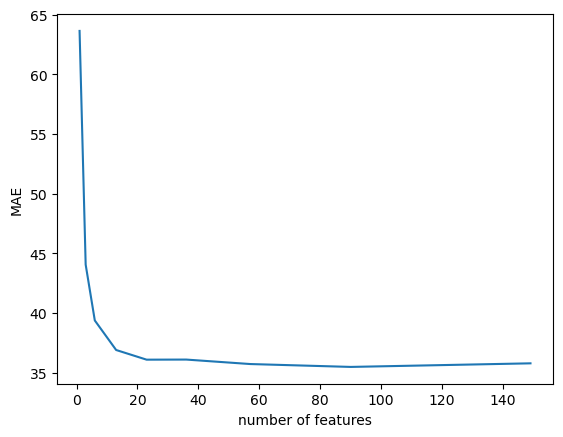

In [106]:
plt.plot(n_feature_list, mae_list)
plt.xlabel("number of features")
plt.ylabel("Test MAE")
plt.show()

### Mutual information

In [88]:
mi_scores = mutual_info_regression(X_train_scaled, y_train_scaled.ravel(), random_state=42)
mi_scores = pd.Series(mi_scores) #, index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores)

432    0.207991
430    0.204619
424    0.189000
14     0.186366
427    0.181103
         ...   
77     0.000000
80     0.000000
331    0.000000
53     0.000000
139    0.000000
Length: 447, dtype: float64


<Axes: title={'center': 'Mutual Information Feature Scores'}>

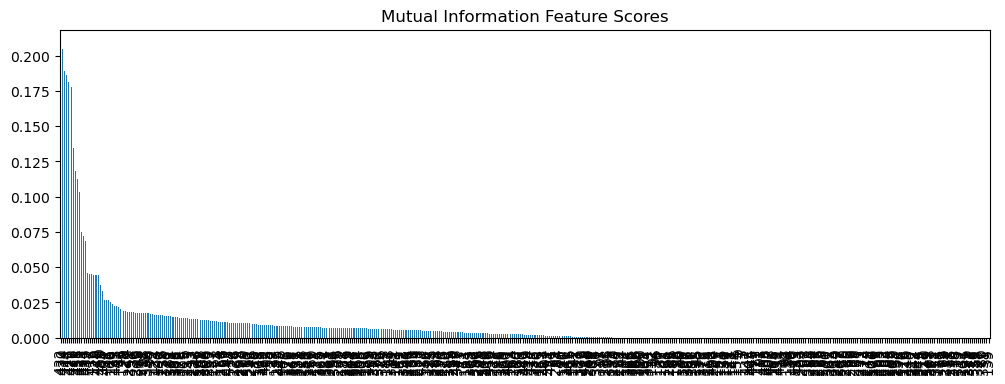

In [89]:
mi_scores.plot.bar(figsize=(12,4), title="Mutual Information Feature Scores")

In [107]:
n_feature_list = []
mae_list = []

for p in np.arange(10, len(X_train.columns), step=10):
    top_features = mi_scores.head(p).index # selecting top p features according to MI
    X_train_selected = X_train_scaled[:, top_features]
    X_test_selected = X_test_scaled[:, top_features]
    
    model = RandomForestRegressor(criterion='absolute_error', n_estimators=100, random_state=42, n_jobs=-1) # optimizing MAE directly
    model.fit(X_train_selected, y_train_scaled.ravel())
    
    y_pred = model.predict(X_test_selected)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    print(f"n_features: {p}, Test MAE: {mean_absolute_error(y_test, y_pred_rescaled):.2f}")
    
    n_feature_list.append(p)
    mae_list.append(mean_absolute_error(y_test, y_pred_rescaled))
    
# MAE around 33 - performs better than PCA - we may select an elbow point

n_features: 10, Test MAE: 37.48
n_features: 20, Test MAE: 34.75
n_features: 30, Test MAE: 34.40
n_features: 40, Test MAE: 34.10
n_features: 50, Test MAE: 34.25
n_features: 60, Test MAE: 33.88
n_features: 70, Test MAE: 33.87
n_features: 80, Test MAE: 33.84
n_features: 90, Test MAE: 33.61
n_features: 100, Test MAE: 33.81
n_features: 110, Test MAE: 33.29
n_features: 120, Test MAE: 33.30
n_features: 130, Test MAE: 33.34
n_features: 140, Test MAE: 33.12
n_features: 150, Test MAE: 33.03
n_features: 160, Test MAE: 33.27
n_features: 170, Test MAE: 33.17
n_features: 180, Test MAE: 33.41
n_features: 190, Test MAE: 33.26
n_features: 200, Test MAE: 33.25
n_features: 210, Test MAE: 33.40
n_features: 220, Test MAE: 33.16
n_features: 230, Test MAE: 33.25
n_features: 240, Test MAE: 33.35
n_features: 250, Test MAE: 33.28
n_features: 260, Test MAE: 33.38
n_features: 270, Test MAE: 33.42
n_features: 280, Test MAE: 33.36
n_features: 290, Test MAE: 33.33
n_features: 300, Test MAE: 33.25
n_features: 310, Te

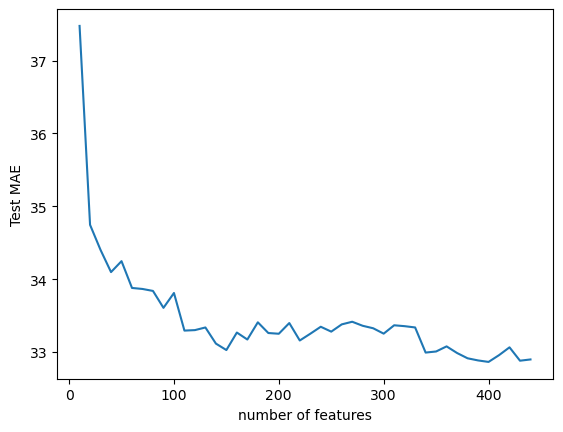

In [108]:
plt.plot(n_feature_list, mae_list)
plt.xlabel("number of features")
plt.ylabel("Test MAE")
plt.show()

# about 150 features looks reasonable

### Correlation

In [109]:
corr_scores = X_train.apply(lambda col: col.corr(y_train), axis=0).abs() # counting it on X_train_scaled should give the same results
corr_scores = corr_scores.sort_values(ascending=False)

n_feature_list_corr = []
mae_list_corr = []

for p in np.arange(10, len(X_train.columns), 10):
    top_features_corr = corr_scores.head(p).index  # select top p features by correlation
    
    X_train_selected = pd.DataFrame(X_train_scaled, columns=X_train.columns)[top_features_corr].values
    X_test_selected  = pd.DataFrame(X_test_scaled, columns=X_train.columns)[top_features_corr].values

    model = RandomForestRegressor(
        criterion='absolute_error',
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_selected, y_train_scaled.ravel())

    y_pred = model.predict(X_test_selected)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

    mae = mean_absolute_error(y_test, y_pred_rescaled)
    print(f"[Corr] n_features: {p}, Test MAE: {mae:.2f}")

    n_feature_list_corr.append(p)
    mae_list_corr.append(mae)

# similar results to MI, maybe slightly better
# MAE around 33

C:\Users\jakub\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\jakub\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[Corr] n_features: 10, Test MAE: 37.76
[Corr] n_features: 20, Test MAE: 36.28
[Corr] n_features: 30, Test MAE: 33.54
[Corr] n_features: 40, Test MAE: 33.17
[Corr] n_features: 50, Test MAE: 33.42
[Corr] n_features: 60, Test MAE: 33.47
[Corr] n_features: 70, Test MAE: 33.27
[Corr] n_features: 80, Test MAE: 33.25
[Corr] n_features: 90, Test MAE: 33.52
[Corr] n_features: 100, Test MAE: 33.37
[Corr] n_features: 110, Test MAE: 33.44
[Corr] n_features: 120, Test MAE: 33.46
[Corr] n_features: 130, Test MAE: 33.16
[Corr] n_features: 140, Test MAE: 33.26
[Corr] n_features: 150, Test MAE: 33.12
[Corr] n_features: 160, Test MAE: 33.05
[Corr] n_features: 170, Test MAE: 33.28
[Corr] n_features: 180, Test MAE: 33.34
[Corr] n_features: 190, Test MAE: 33.10
[Corr] n_features: 200, Test MAE: 33.14
[Corr] n_features: 210, Test MAE: 33.00
[Corr] n_features: 220, Test MAE: 32.92
[Corr] n_features: 230, Test MAE: 33.02
[Corr] n_features: 240, Test MAE: 32.89
[Corr] n_features: 250, Test MAE: 33.02
[Corr] n_

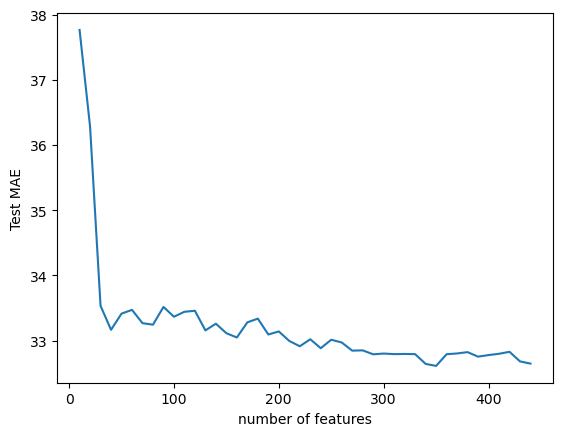

In [110]:
plt.plot(n_feature_list_corr, mae_list_corr)
plt.xlabel("number of features")
plt.ylabel("Test MAE")
plt.show()

# top 40, 160 features is good -> let's take 160 (similar to MI results)

## Modelling

#### At this step we look for the best model and hyperparameters, after finding it, we may potentially train the final model on the full set

In [115]:
# we take top 160 features based on correlation

N_FEATURES = 160
top_features_corr = corr_scores.head(N_FEATURES).index
X_train_selected = pd.DataFrame(X_train_scaled, columns=X_train.columns)[top_features_corr].values
X_test_selected  = pd.DataFrame(X_test_scaled, columns=X_train.columns)[top_features_corr].values

[Corr] n_features: 440, Test MAE: 33.05


In [133]:
# saving features
os.makedirs("features", exist_ok=True)
joblib.dump(top_features_corr, "features/selected_features.pkl")
joblib.dump(X_train.columns, "features/all_features.pkl")

['features/all_features.pkl']

In [127]:
# defining models and their hyperparameter grids

models = {
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "Ridge": Ridge(),
    "KNN": KNeighborsRegressor()
}

param_grids = {
    "RandomForest": {
        "model__n_estimators": [100, 200, 300, 500],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["auto", "sqrt", "log2"]
    },
    "GradientBoosting": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "model__max_depth": [3, 5, 7],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__subsample": [0.7, 0.85, 1.0]
    },
    "SVR": {
        "model__C": [0.1, 1, 10, 50],
        "model__gamma": ["scale", "auto", 0.01, 0.1],
        "model__kernel": ["rbf", "poly", "sigmoid"],
        "model__degree": [2, 3, 4]
    },
    "Ridge": {
        "model__alpha": [0.01, 0.1, 1, 10, 50, 100],
        "model__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]
    }
}

In [128]:
# comparing models

os.makedirs("models", exist_ok=True)

results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    pipeline = Pipeline([
        ("model", model)
    ])
    
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )
    
    grid.fit(X_train_selected, y_train_scaled.ravel())
    
    # Predict and rescale target
    y_pred_scaled = grid.predict(X_test_selected)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"{name} best params: {grid.best_params_}")
    print(f"{name} Test MAE: {mae:.3f}\n")
    
    # Save model
    joblib.dump(grid.best_estimator_, f"models/{name}_best_model.pkl")
    
    # Store results
    results.append({
        "model": name,
        "mae": mae,
        "best_params": grid.best_params_
    })

results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison.csv", index=False)

Training RandomForest...


C:\Users\jakub\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jakub\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jakub\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jakub\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator

RandomForest best params: {'model__max_depth': 30, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
RandomForest Test MAE: 32.630

Training GradientBoosting...
GradientBoosting best params: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 300, 'model__subsample': 0.7}
GradientBoosting Test MAE: 30.923

Training SVR...
SVR best params: {'model__C': 50, 'model__degree': 2, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
SVR Test MAE: 32.164

Training Ridge...
Ridge best params: {'model__alpha': 1, 'model__solver': 'sparse_cg'}
Ridge Test MAE: 36.858

Training KNN...
KNN best params: {'model__n_neighbors': 7, 'model__p': 1, 'model__weights': 'distance'}
KNN Test MAE: 37.039



In [129]:
results_df
# gradient boosting gives the best results - MAE about 30

,model,mae,best_params
0,RandomForest,32.630003,"{'model__max_depth': 30, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}"
1,GradientBoosting,30.922922,"{'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 300, 'model__subsample': 0.7}"
2,SVR,32.163609,"{'model__C': 50, 'model__degree': 2, 'model__gamma': 0.1, 'model__kernel': 'rbf'}"
3,Ridge,36.857574,"{'model__alpha': 1, 'model__solver': 'sparse_cg'}"
4,KNN,37.038685,"{'model__n_neighbors': 7, 'model__p': 1, 'model__weights': 'distance'}"


## Pipeline for preparing new data and prediction

In [ ]:
# perform feature extraction using the functions above
# normalize data using saved scalers
# make sure that the features of incoming data are the same as training features, so we should load selected features from 'features' directory
# load model (maybe we want to train the final model on the full set?)
# perform prediction (and rescale results)
# return results and save them in a submission file (format specified at https://www.kaggle.com/competitions/melting-point/data)

## EDA

In [40]:
y

0       213.15
1       407.15
2       324.15
3       351.15
4       126.15
         ...  
2657    256.45
2658    231.15
2659    256.25
2660    333.15
2661    328.15
Name: Tm, Length: 2662, dtype: float64

Top 50 variables most correlated with the target:
Group 15     0.387580
Group 18     0.223551
Group 16     0.223530
Group 401    0.222525
Group 17     0.194420
Group 1      0.186595
Group 123    0.179178
Group 365    0.176346
Group 31     0.171773
Group 412    0.165621
Group 30     0.162579
Group 5      0.158361
Group 326    0.151604
Group 62     0.150432
Group 373    0.129026
Group 403    0.125958
Group 126    0.122881
Group 221    0.120362
Group 180    0.114525
Group 19     0.110682
Group 392    0.110205
Group 7      0.109899
Group 119    0.109563
Group 227    0.109124
Group 32     0.107192
Group 372    0.106768
Group 80     0.106296
Group 3      0.104648
Group 229    0.104042
Group 170    0.101924
Group 328    0.100826
Group 98     0.099892
Group 20     0.099776
Group 53     0.096433
Group 175    0.093156
Group 176    0.091605
Group 2      0.089414
Group 409    0.087669
Group 129    0.086298
Group 222    0.085987
Group 367    0.085266
Group 388    0.085180
Group 86     0.084960
Grou

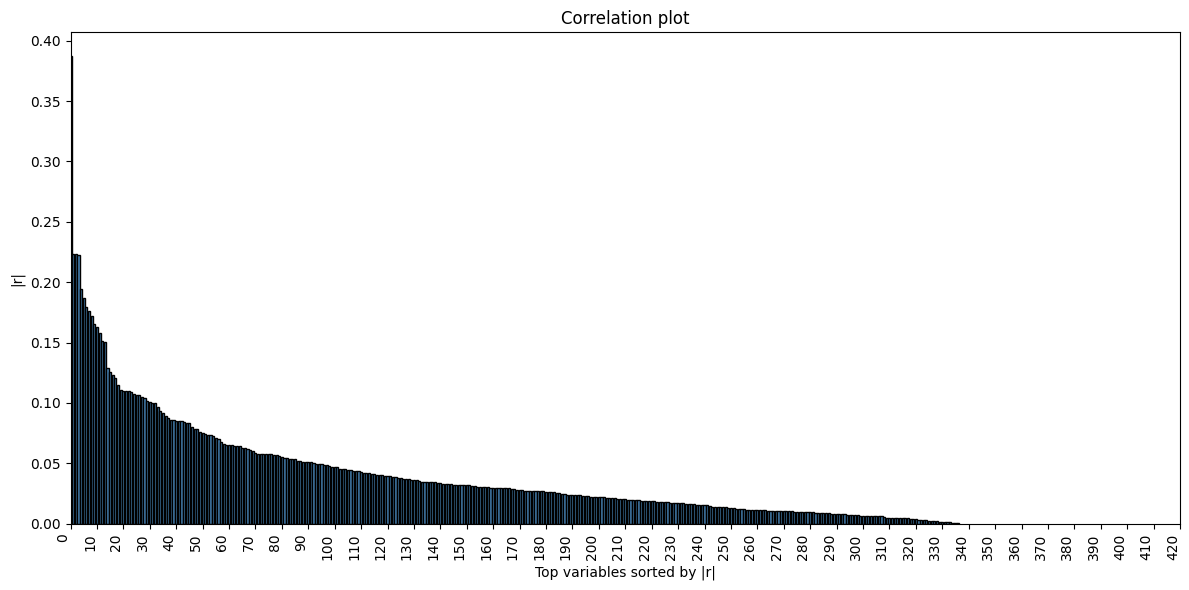

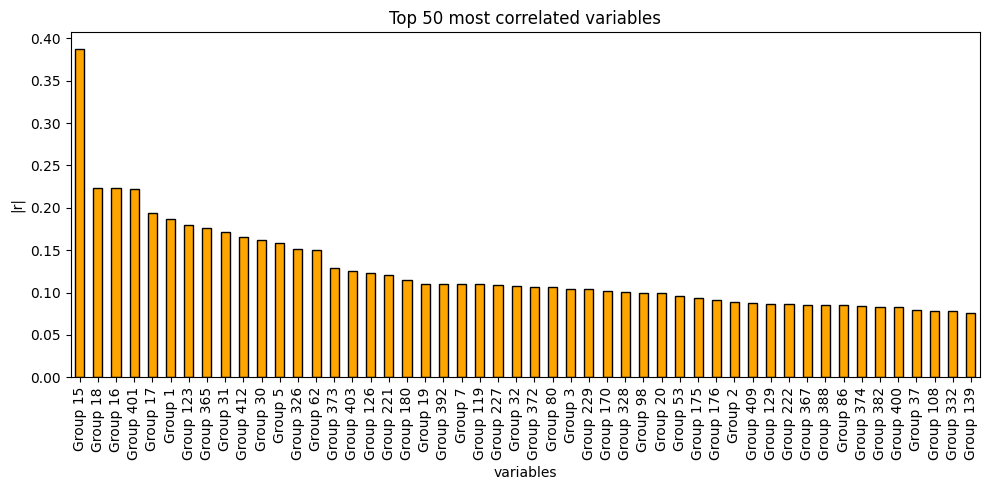

In [41]:
df_corr = pd.concat([X, y], axis=1).select_dtypes(include='number')

correlations = df_corr.corr(numeric_only=True)['Tm'].drop('Tm')

abs_corr = correlations.abs().sort_values(ascending=False)

top50 = abs_corr.head(50)

print("Top 50 variables most correlated with the target:")
print(top50)


plt.figure(figsize=(12, 6))
plt.bar(range(len(abs_corr)), abs_corr.values, color='steelblue', edgecolor='black')
plt.title("Correlation plot")
plt.ylabel("|r|")
plt.xlabel("Top variables sorted by |r|")

step = 10
xticks_idx = range(0, len(abs_corr), step)
plt.xticks(xticks_idx, xticks_idx, rotation=90, ha='right')
plt.xlim(0, 420)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top50.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Top 50 most correlated variables")
plt.ylabel("|r|")
plt.xlabel("variables")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

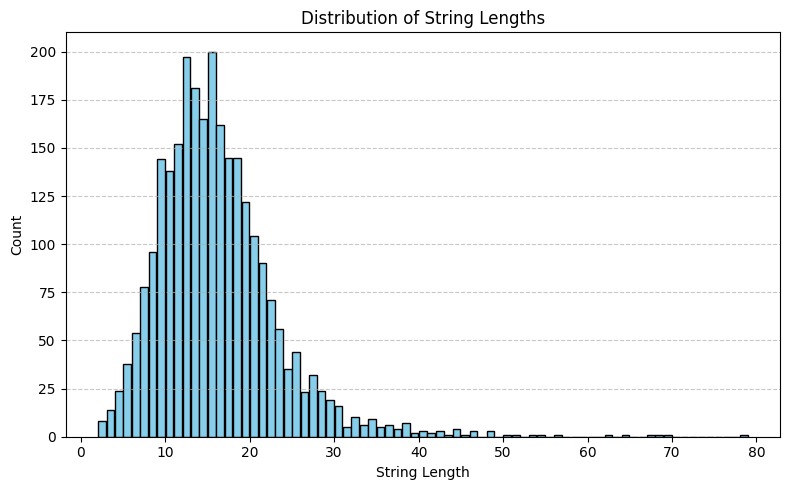

In [42]:
texts = smiles.tolist()
# Compute string lengths
lengths = [len(t) for t in texts]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 2), color='skyblue', edgecolor='black', rwidth=0.9)

plt.title("Distribution of String Lengths")
plt.xlabel("String Length")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Cut to 50 is reasonable

In [43]:
X[top50.index]

,Group 15,Group 18,Group 16,Group 401,Group 17,Group 1,Group 123,Group 365,Group 31,Group 412,...,Group 367,Group 388,Group 86,Group 374,Group 382,Group 400,Group 37,Group 108,Group 332,Group 139
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,0,2,2,4,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,1,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2659,6,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2660,7,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Evaluate 5-fold CV MAE for different top feature counts
for n in range(10,420,10):
    top_features = abs_corr.head(n).index

    model = LinearRegression()
    
    # 5-fold cross-validation, scoring='neg_mean_absolute_error'
    scores = cross_val_score(model, X[top_features], y, cv=10, scoring='neg_mean_absolute_error')
    
    mae_mean = -scores.mean()  # negate because scores are negative
    mae_std = scores.std()
    
    print(f"Top {n} features → 5-fold CV MAE: {mae_mean:.4f} ± {mae_std:.4f}")


Top 10 features → 5-fold CV MAE: 55.4026 ± 1.8828
Top 20 features → 5-fold CV MAE: 50.6283 ± 2.4304
Top 30 features → 5-fold CV MAE: 48.8196 ± 2.6177
Top 40 features → 5-fold CV MAE: 45.8942 ± 2.5269
Top 50 features → 5-fold CV MAE: 44.6979 ± 2.3409
Top 60 features → 5-fold CV MAE: 44.3393 ± 2.3515
Top 70 features → 5-fold CV MAE: 44.0362 ± 2.4129
Top 80 features → 5-fold CV MAE: 43.9061 ± 2.1370
Top 90 features → 5-fold CV MAE: 1850062775.7812 ± 5550188197.1494
Top 100 features → 5-fold CV MAE: 43.6169 ± 2.4287
Top 110 features → 5-fold CV MAE: 43.3516 ± 2.2590
Top 120 features → 5-fold CV MAE: 8552320357.5821 ± 25656960945.2265
Top 130 features → 5-fold CV MAE: 42.2208 ± 2.1311
Top 140 features → 5-fold CV MAE: 7301888741.6702 ± 21905666099.8605
Top 150 features → 5-fold CV MAE: 2212705792.7358 ± 6638117253.6174
Top 160 features → 5-fold CV MAE: 25135530865.0111 ± 75406592471.1843
Top 170 features → 5-fold CV MAE: 28065807557.1333 ± 84197422225.5278
Top 180 features → 5-fold CV MAE: 

ValueError: x and y must be the same size

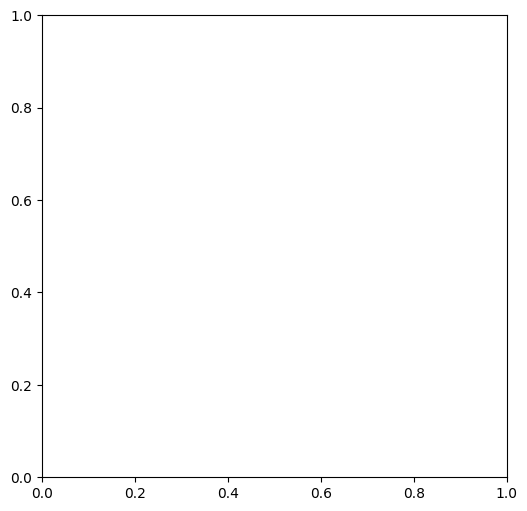

In [45]:

# Assuming you already have:
# y_test (true values)
# y_pred (predicted values)
y_test = y
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='steelblue', alpha=0.6, edgecolor='k')

plt.title("Actual vs Predicted Values")
plt.xlabel("Actual (True) Values")
plt.ylabel("Predicted Values")
plt.tight_layout()
plt.show()


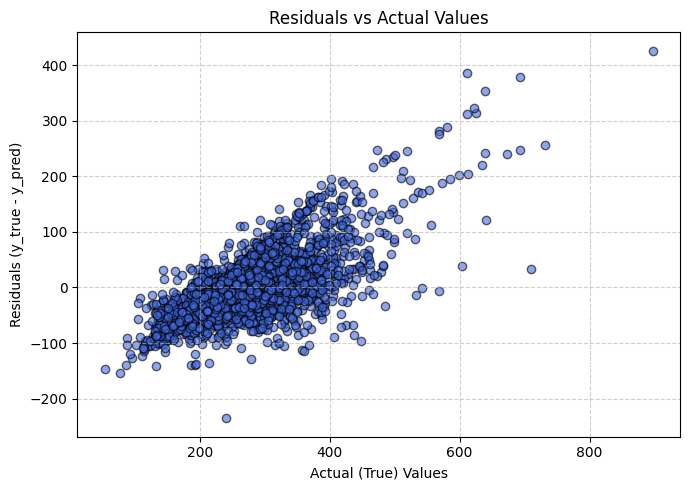

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_test, residuals, color='royalblue', alpha=0.6, edgecolor='k')
#plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title("Residuals vs Actual Values")
plt.xlabel("Actual (True) Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()